## Image Classification

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import cv2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import datetime
import os

import warnings
warnings.filterwarnings("ignore")


Ładowanie i wstępne przetwarzanie obrazów

In [2]:
img = cv2.imread(r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled\disco\3_1.jpg")
type(img)

numpy.ndarray

In [3]:
print(img.shape,img.dtype)

(397, 400, 3) uint8


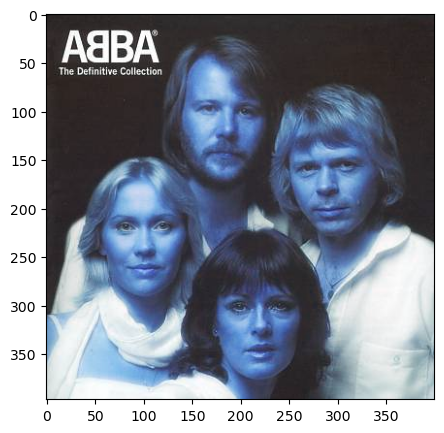

In [4]:
fig = plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=gIjgz7_JIo_m

# Transfer Learning

In [5]:
# define some parameters for the loader:
batch_size = 15
img_height = 224
img_width = 224

# path to the folders with data on my drive
data_dir=r"C:\Users\toawe\OneDrive\Pulpit\dl\archive (9)\images labeled\images labeled" 

train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=100, #losowanie zmieniec
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9311 files belonging to 5 classes.
Using 8380 files for training.
Found 9311 files belonging to 5 classes.
Using 931 files for validation.


In [6]:
class_names = train_ds.class_names # in this method labels are generated from the directory structure
print(class_names)
print(len(class_names))

['disco', 'electro', 'folk', 'rap', 'rock']
5


In [7]:
num_classes = len(class_names)

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(15, 224, 224, 3)
(15,)


In [9]:
image_batch.shape

TensorShape([15, 224, 224, 3])

In [10]:
labels_batch.shape

TensorShape([15])

In [11]:
# standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06079576 1.0


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize the data

Here are the first 12 images from the training dataset AND from the validation dataset:

In [14]:
def visualize():
    
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

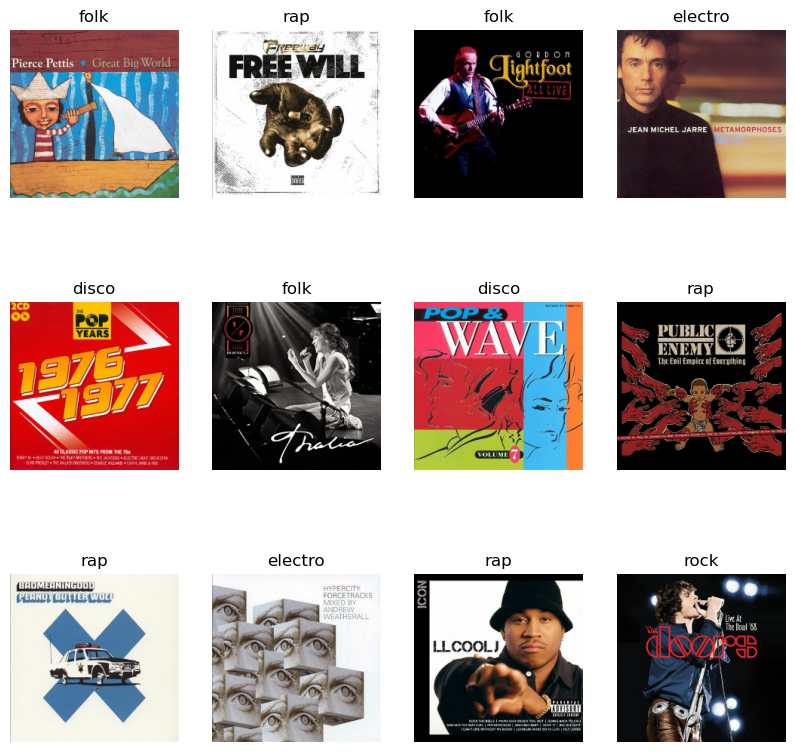

In [17]:
visualize()

In [59]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 

In [60]:
unique_train_labels = np.unique(train_label, return_counts=True)
unique_test_labels = np.unique(test_label, return_counts=True)

In [75]:
uniqe_labels = unique_train_labels[1]+unique_test_labels[1]
uniqe_labels 

array([1783, 1864, 1900, 1853, 1911], dtype=int64)

Text(0.5, 1.0, 'Number of album covers per categories')

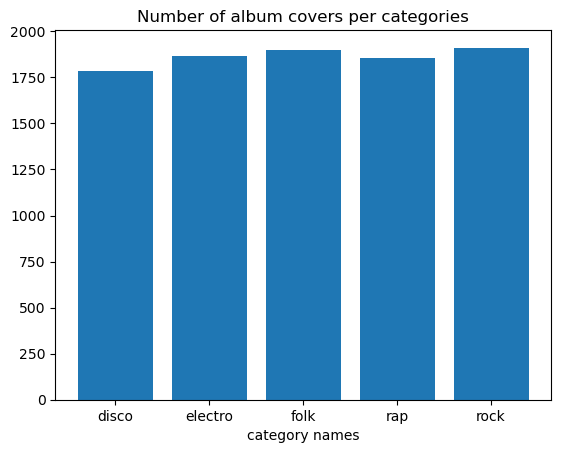

In [78]:
# wykreślamy ilościowy udział klas
plt.bar(
    x=train_ds.class_names,
    height=uniqe_labels 
)
plt.xlabel('category names')
plt.title('Number of album covers per categories')

# EfficientNetB1

In [18]:
# wejście
batch_size = 15
input_shape = (224,224,3)
inputLayer = tf.keras.Input(shape=(input_shape))

In [19]:
# bierzemy wytrenowany wcześniej model
base_model_1 = tf.keras.applications.efficientnet.EfficientNetB1(
    #alpha=1.0,
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy klasyfikatora, sami swoją dodamy

# nie chcemy aby nauczony już feature extractor się uczył
base_model_1.trainable = False

# dodajemy ostatnie warstwy klasyfikatora
x = base_model_1(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x) # dodatkowa warstwa
output = layers.Dense(num_classes, activation="softmax")(x)

# to reduce overfitting is to introduce dropout{:.external} regularization to the network.
#Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. 
# This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

# zamykamy w kerasowy model
model_1 = tf.keras.Model(inputLayer, output)
model_1.summary()

# kompilujemy całość
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#zmienieniony lr
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                             

In [20]:
%%time

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5


559/559 [==============================] - 260s 452ms/step - loss: 1.3110 - accuracy: 0.4589 - val_loss: 1.1941 - val_accuracy: 0.5263
Epoch 2/5
559/559 [==============================] - 260s 464ms/step - loss: 1.1024 - accuracy: 0.5723 - val_loss: 1.1464 - val_accuracy: 0.5467
Epoch 3/5
559/559 [==============================] - 247s 442ms/step - loss: 1.0080 - accuracy: 0.6147 - val_loss: 1.1248 - val_accuracy: 0.5542
Epoch 4/5
559/559 [==============================] - 248s 443ms/step - loss: 0.9246 - accuracy: 0.6572 - val_loss: 1.1151 - val_accuracy: 0.5596
Epoch 5/5
559/559 [==============================] - 246s 440ms/step - loss: 0.8586 - accuracy: 0.6827 - val_loss: 1.1045 - val_accuracy: 0.5693
Wall time: 21min


#### Visualize training results

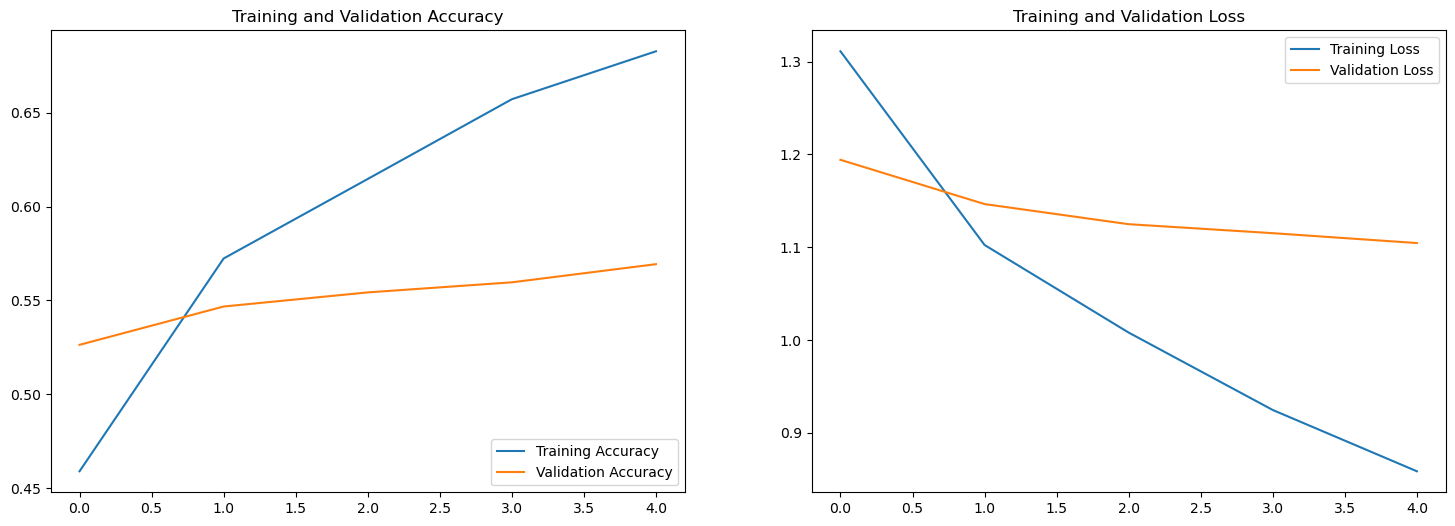

In [21]:
epochs=5
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Data augmentation

This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

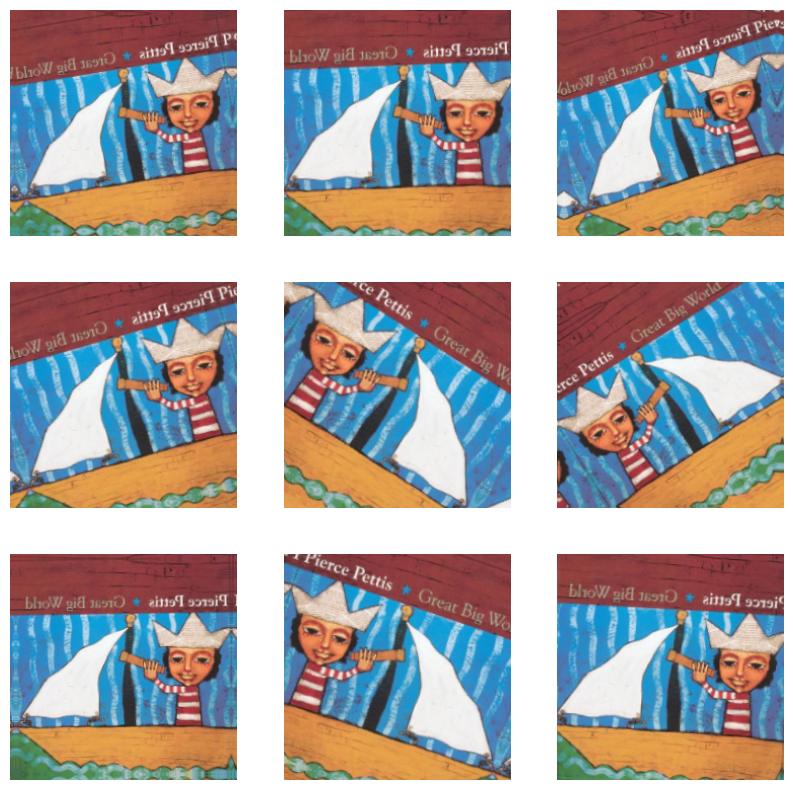

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will add data augmentation to your model before training in the next step.

In [51]:

# bierzemy wytrenowany wcześniej model
base_model_1 = tf.keras.applications.efficientnet.EfficientNetB1(
    #alpha=1.0,
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy klasyfikatora, sami swoją dodamy

# nie chcemy aby nauczony już feature extractor się uczył
base_model_1.trainable = False

# dodajemy ostatnie warstwy klasyfikatora
x = data_augmentation(inputLayer)
x = base_model_1(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x) # dodatkowa warstwa
output = layers.Dense(num_classes, activation="softmax")(x)

# to reduce overfitting is to introduce dropout{:.external} regularization to the network.
#Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. 
# This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

# zamykamy w kerasowy model
model_2 = tf.keras.Model(inputLayer, output)
model_2.summary()

# kompilujemy całość
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#zmienieniony lr
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                           

In [22]:
%%time

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
559/559 [==============================] - 268s 465ms/step - loss: 1.3053 - accuracy: 0.4643 - val_loss: 1.1950 - val_accuracy: 0.5091
Epoch 2/10
559/559 [==============================] - 284s 508ms/step - loss: 1.1019 - accuracy: 0.5692 - val_loss: 1.1475 - val_accuracy: 0.5317
Epoch 3/10
559/559 [==============================] - 272s 486ms/step - loss: 1.0076 - accuracy: 0.6143 - val_loss: 1.1234 - val_accuracy: 0.5553
Epoch 4/10
559/559 [==============================] - 286s 511ms/step - loss: 0.9278 - accuracy: 0.6587 - val_loss: 1.1125 - val_accuracy: 0.5564
Epoch 5/10
559/559 [==============================] - 274s 490ms/step - loss: 0.8594 - accuracy: 0.6852 - val_loss: 1.1029 - val_accuracy: 0.5682
Epoch 6/10
559/559 [==============================] - 269s 481ms/step - loss: 0.7952 - accuracy: 0.7107 - val_loss: 1.0984 - val_accuracy: 0.5671
Epoch 7/10
559/559 [==============================] - 257s 459ms/step - loss: 0.7397 - accuracy: 0.7379 - val_loss: 1.1039 -

# Model Evaluation

visualize the training results after adding data augumentation into aur model

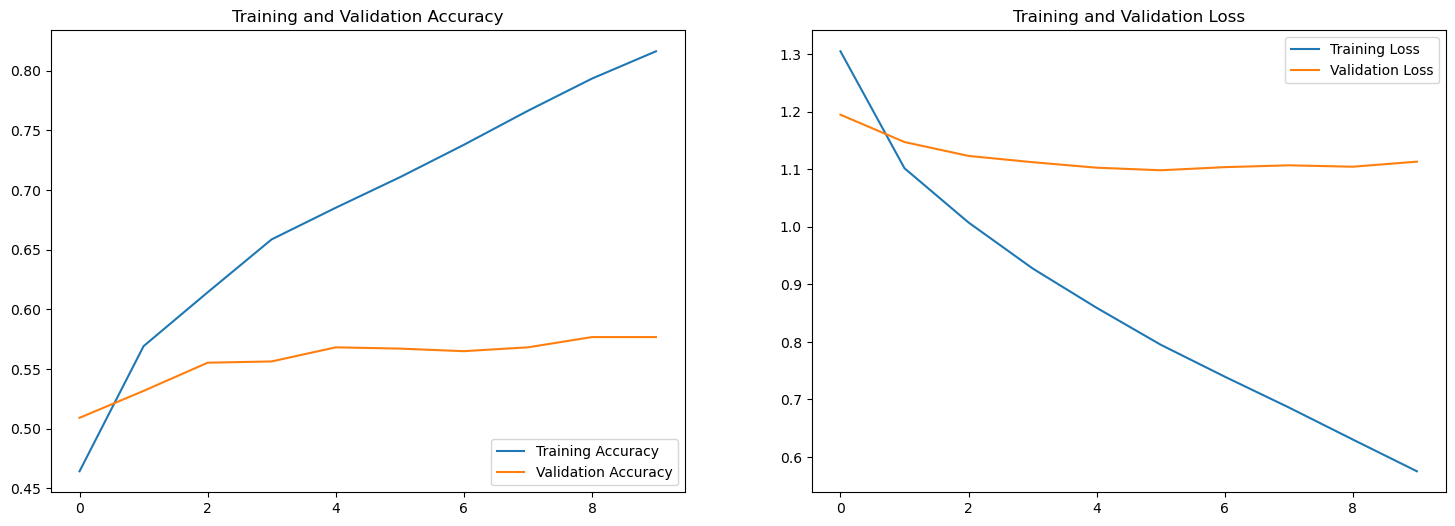

In [23]:
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
score = model_2.evaluate(val_ds, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.1134326457977295
Test accuracy: 0.5767991542816162


In [66]:
from keras import metrics

In [25]:
test_loss, test_acc = model_2.evaluate_generator(val_ds, steps=50)

In [26]:
print('test acc:', test_acc)
print('test loss:', test_loss)

test acc: 0.5853333473205566
test loss: 1.097822666168213


# Predict on new data

We will use our model to classify an image that wasn't included in the training or validation sets.

In [27]:
sunflower_path = r"C:\Users\toawe\OneDrive\Pulpit\dl\predict_covers\disco_img_album_cover.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 4s 4s/step
This image most likely belongs to rock with a 23.17 percent confidence.


In [28]:
sunflower_path = r"C:\Users\toawe\OneDrive\Pulpit\dl\predict_covers\folk_img_album_cover.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 71ms/step
This image most likely belongs to folk with a 35.43 percent confidence.


In [29]:
sunflower_path = r"C:\Users\toawe\OneDrive\Pulpit\dl\predict_covers\rap_img_album_cover.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)) 
)

1/1 [==============================] - 0s 58ms/step
This image most likely belongs to rock with a 34.81 percent confidence.


In [37]:
predictions = model_2.predict(val_ds)

63/63 [==============================] - 25s 372ms/step


In [23]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 

In [31]:
test_label 

array([0, 3, 4, 3, 4, 3, 4, 1, 3, 2, 3, 2, 3, 1, 1, 0, 2, 0, 4, 3, 0, 4,
       3, 1, 2, 2, 2, 1, 3, 0, 3, 1, 0, 3, 4, 0, 1, 3, 4, 2, 1, 3, 3, 0,
       1, 4, 4, 4, 0, 4, 3, 0, 3, 1, 3, 3, 0, 4, 4, 2, 0, 4, 1, 1, 1, 2,
       0, 0, 1, 1, 0, 4, 1, 2, 3, 3, 1, 4, 4, 0, 4, 2, 4, 1, 2, 0, 2, 3,
       4, 2, 1, 1, 2, 2, 2, 4, 0, 0, 1, 3, 4, 0, 0, 1, 3, 1, 4, 4, 4, 2,
       2, 3, 4, 4, 3, 0, 2, 4, 1, 0, 4, 2, 2, 1, 3, 0, 1, 1, 2, 3, 2, 2,
       2, 1, 3, 3, 4, 3, 3, 1, 2, 2, 0, 4, 1, 3, 4, 4, 1, 2, 2, 4, 1, 2,
       0, 4, 0, 4, 3, 4, 3, 3, 3, 2, 2, 2, 4, 2, 1, 4, 0, 0, 4, 1, 4, 4,
       1, 4, 2, 4, 0, 1, 1, 4, 4, 3, 1, 0, 2, 2, 2, 4, 0, 4, 4, 3, 4, 3,
       0, 4, 0, 0, 4, 0, 3, 0, 4, 0, 2, 4, 3, 1, 4, 2, 3, 3, 1, 3, 4, 3,
       0, 1, 3, 1, 4, 0, 2, 1, 3, 1, 0, 1, 3, 1, 0, 4, 2, 2, 0, 0, 3, 0,
       3, 1, 0, 1, 2, 1, 1, 0, 1, 3, 3, 4, 1, 0, 4, 2, 2, 1, 3, 4, 2, 4,
       1, 4, 1, 0, 1, 4, 2, 4, 0, 3, 4, 3, 0, 4, 2, 1, 2, 1, 4, 2, 3, 2,
       1, 2, 4, 3, 0, 4, 1, 0, 3, 3, 4, 2, 1, 4, 4,

In [32]:
test_label.shape

(931,)

In [38]:
predictions.shape

(931, 5)

In [39]:
predictions = np.argmax(predictions, axis=1)

In [40]:
predictions

array([4, 3, 0, 3, 4, 3, 4, 3, 2, 2, 4, 0, 4, 0, 2, 0, 2, 0, 2, 3, 2, 4,
       3, 3, 2, 2, 4, 1, 1, 4, 1, 0, 4, 3, 1, 1, 1, 2, 4, 3, 1, 3, 0, 0,
       4, 4, 4, 4, 0, 0, 1, 0, 3, 1, 3, 2, 0, 2, 4, 2, 0, 4, 1, 2, 0, 1,
       0, 4, 3, 1, 0, 4, 0, 2, 3, 3, 1, 0, 2, 4, 3, 2, 4, 3, 2, 1, 4, 3,
       4, 0, 1, 1, 1, 2, 2, 2, 3, 3, 1, 3, 4, 0, 0, 0, 3, 1, 1, 4, 4, 1,
       2, 3, 1, 4, 1, 1, 2, 4, 1, 0, 4, 4, 2, 1, 1, 2, 1, 2, 1, 3, 2, 2,
       2, 1, 3, 3, 4, 4, 3, 1, 4, 2, 0, 3, 0, 3, 4, 4, 0, 2, 2, 4, 2, 2,
       0, 4, 0, 2, 3, 4, 3, 0, 3, 4, 1, 2, 2, 2, 0, 3, 0, 0, 3, 4, 4, 4,
       1, 4, 1, 4, 2, 1, 3, 4, 3, 3, 2, 0, 2, 4, 2, 2, 3, 4, 4, 3, 3, 3,
       0, 0, 0, 2, 0, 2, 3, 3, 4, 0, 2, 3, 0, 1, 0, 2, 3, 3, 0, 3, 4, 3,
       0, 3, 3, 1, 4, 0, 1, 3, 3, 1, 0, 3, 3, 4, 0, 4, 1, 2, 0, 2, 3, 0,
       3, 3, 3, 1, 1, 1, 1, 0, 1, 2, 1, 4, 1, 0, 3, 2, 4, 3, 2, 1, 2, 4,
       1, 1, 4, 3, 1, 1, 1, 4, 1, 3, 4, 1, 0, 4, 2, 1, 4, 1, 3, 2, 1, 4,
       1, 1, 4, 4, 0, 2, 1, 0, 1, 3, 1, 3, 1, 0, 4,

In [41]:
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       164
           1       0.56      0.60      0.58       206
           2       0.54      0.51      0.53       177
           3       0.58      0.58      0.58       192
           4       0.58      0.59      0.59       192

    accuracy                           0.58       931
   macro avg       0.58      0.58      0.58       931
weighted avg       0.58      0.58      0.58       931



In [42]:
#create confusion matrix

confusionMatrix = tf.math.confusion_matrix(labels=test_label, predictions=predictions).numpy()

In [259]:
confusionMatrix

array([[31, 38, 36, 30, 29],
       [32, 40, 43, 35, 56],
       [34, 41, 30, 37, 35],
       [32, 50, 33, 38, 39],
       [35, 49, 34, 37, 37]])

In [43]:
p = model_2.predict_generator(val_ds)

In [48]:
print(classification_report(test_label, np.argmax(p, axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       164
           1       0.56      0.60      0.58       206
           2       0.54      0.51      0.53       177
           3       0.58      0.58      0.58       192
           4       0.58      0.59      0.59       192

    accuracy                           0.58       931
   macro avg       0.58      0.58      0.58       931
weighted avg       0.58      0.58      0.58       931



In [50]:
# to sprawdz
score = model_2.evaluate(val_ds ,verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.1134326457977295
Test accuracy: 0.5767991542816162


In [262]:
#zapisanie modelu 

model_2.save('model_1.h5')